## TYK2 VAMP-seq Midpoint Inference

For the first mini-VAMP-seq experiment, we have four activity bins ordered low to high and with approximately (but not exactly) equal widths. This document walks through a prototype modeling procedure for these data using position 669 as a test case. This is a useful position since it contains a spike-in (669P) as well as the usual stop effect. We include all non-WT variants at this position, as well as a sampling (1000 barcodes per sample) of the WT barcodes.

1. [Background and Descriptive Profiling](#part1)
2. [Adapting the DMS Model to VAMP-seq](#part2)
3. [Rescaling Coefficients to Weights](#part3)
4. [Inferring Differences from WT](#part4)
5. [Extension to Chunk 10](#part5)

In [2]:
library(magrittr)
library(data.table)
library(ggpubr)
library(vroom)
library(scales)
library(GGally)
library(MASS)
library(brms)
library(glmmTMB)
library(ggbeeswarm)
library(scico)
library(ggridges)
library(emmeans)
library(knitr)
library(fs)
library(broom)
library(broom.mixed)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

source("../src/model_utils.R")

### Background and Descriptive Profiling <a name="part1"></a>

Let's start by looking at what we got using the original DMS model with VAMP-seq data. For this model, we estimated the mutant vs WT effects within each bin individually:

In [3]:
sumstats_orig <- read_tsv("../sumstats/TYK2-VAMP/run1/tyk2-vamp-mini_10-combined.sumstats.tsv") %>%
    filter(pos == 669, grepl("mut_aaP|mut_aa\\*", term), grepl("conditionC", term)) %>%
    mutate(term = gsub("condition|mut_aa", "", term)) %>%
    separate(term, c("sample", "aa"), sep = ":") %>%
    mutate(sample = as.numeric(str_sub(sample, 2, 5)))

Rows: 23398 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): term, version
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


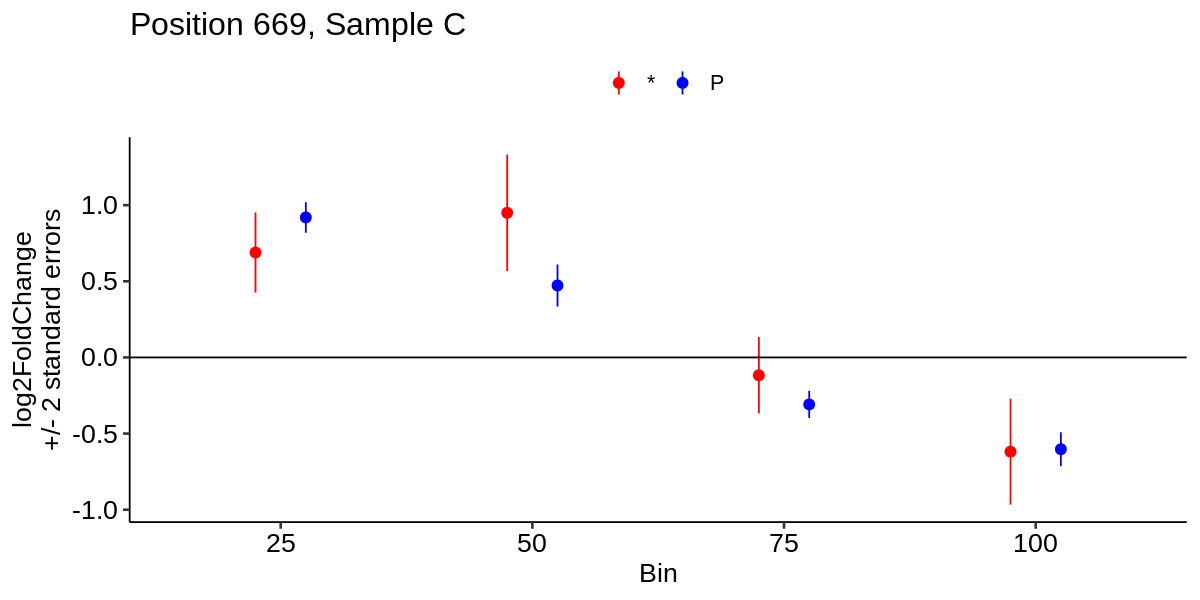

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5)
sumstats_orig %>%
    ggplot() +
        geom_pointrange(aes(x = as.factor(sample), y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error,
                            color = aa), position = position_dodge(width = 0.4)) +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("log2FoldChange\n+/- 2 standard errors") +
        ggtitle("Position 669, Sample C") +
        scale_color_manual(values = c("*" = "red", "P" = "blue")) +
        theme(legend.title = element_blank()) +
        geom_hline(yintercept = 0)

The shared pattern is increased abundance in low-activity bins, and reduced abundance in high-activity bins, relative to WT. This is why the linear slope across these intervals do a decent, but non-optimal, job of capturing GoF or LoF patterns. To examine the underlying model in more detail, let's regenerate it and extract the WT and mutant averages separately:

In [6]:
mapped_counts <- vroom("../pipeline/OCNT-VAMPLIB-1-assay-run1/tyk2-vamp-mini-form.mapped-counts-10.tsv",
                  col_names = c("sample", "barcode", "count", "lib", "chunk", 
                                "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                "dox", "chunkID", "condition", "condition_conc","clone"))  %>%
    mutate(condition_conc = if_else(condition_conc == 101, 100, condition_conc),
           condition = str_c(condition, condition_conc),
           mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    group_by(sample) %>%
    mutate(mean_count = mean(log(count)),
           stop_count = sum(count[which(mut_aa == "*")]),
           total_count = log(sum(count)))

mapped_counts669 <- mapped_counts %>% filter(mut_aa == "WT" | pos == 669, grepl("C", sample))
wt_counts <- mapped_counts669 %>% filter(mut_aa == "WT") %>% sample_n(2000)

model_counts <- mapped_counts669 %>%
    filter(mut_aa != "WT") %>%
    bind_rows(wt_counts) %>%
    mutate(group = str_c(str_sub(condition, 1, 1), "_", condition_conc, "_", mut_aa),
           condition_conc = factor(as.character(condition_conc),
                                   levels = c("100", "75", "50", "25")))

Rows: 641329 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition
dbl (4): count, chunk, pos, condition_conc
lgl (3): dox, chunkID, clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
form <- as.formula(count ~ -1 + condition_conc + condition_conc:mut_aa + (1 | barcode) + offset(log(stop_count)))
mod <- glmmTMB(formula = form,
            REML = TRUE,
            start = -1,
            control = glmmTMBControl(optimizer = optim,
                 optArgs = list(method = "L-BFGS-B",
                    pgtol = 0,
                    rel.tol = 0.1)),
            data = model_counts,
            family = nbinom2)

coefs <- tidy(emmeans(mod, ~mut_aa + condition_conc))

NOTE: A nesting structure was detected in the fitted model:
    mut_aa %in% condition_conc



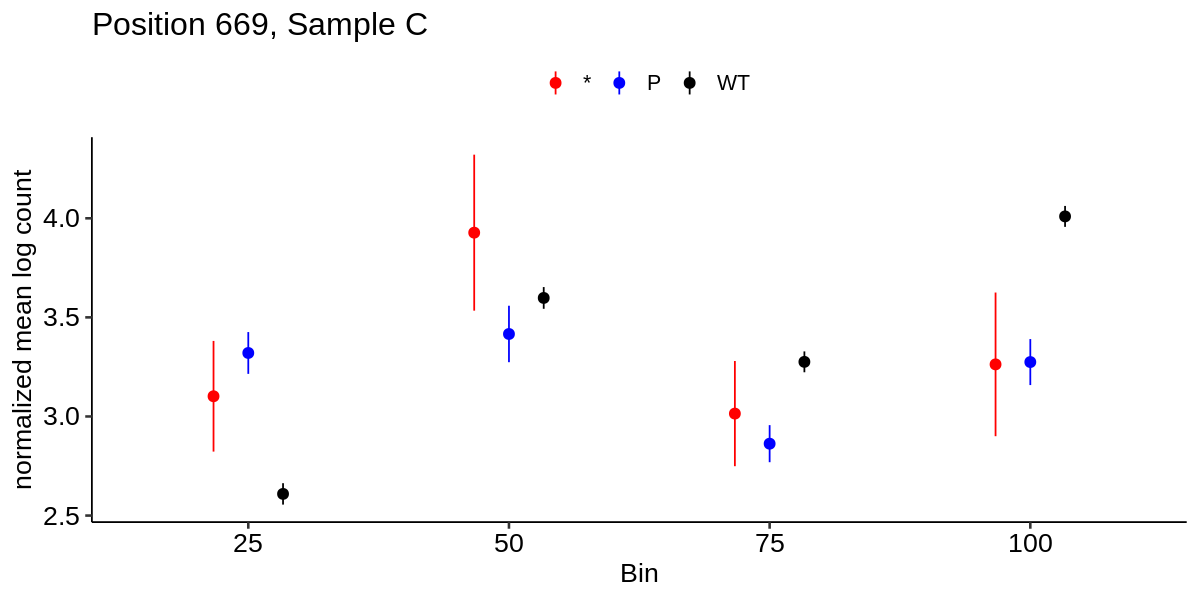

In [10]:
options(repr.plot.width = 10, repr.plot.height = 5)
coefs %>%
    filter(mut_aa %in% c("WT", "*", "P")) %>%
    mutate(condition_conc = factor(condition_conc, levels = c(25, 50, 75, 100))) %>%
    ggplot()  +
        geom_pointrange(aes(x = as.factor(condition_conc), y = (estimate),
                            ymin = (estimate - 2*std.error),
                            ymax = (estimate + 2*std.error),
                            color = mut_aa), position = position_dodge(width = 0.4)) +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("normalized mean log count") +
        ggtitle("Position 669, Sample C") +
        scale_color_manual(values = c("*" = "red", "P" = "blue", "WT" = "black")) +
        theme(legend.title = element_blank())

This is unusual: it looks like bin 50 is markedly higher than the others, particularly for WT. We can examine the underlying raw counts and count the total read counts, the number of unique barcodes, and the actual distributions directly:

In [5]:
mapped_counts %>% count(total_count) %>%
    filter(grepl("C", sample)) %>%
    rename("total read count" = "total_count", "unique barcode count" = "n") %>%
    mutate(sample = factor(sample, levels = c("C25", "C50", "C75", "C100"))) %>%
    arrange(sample) %>%
    kable("markdown")



|sample | total read count| unique barcode count|
|:------|----------------:|--------------------:|
|C25    |         14.98547|                69178|
|C50    |         15.38236|                29886|
|C75    |         15.48106|               104692|
|C100   |         15.41413|                67064|

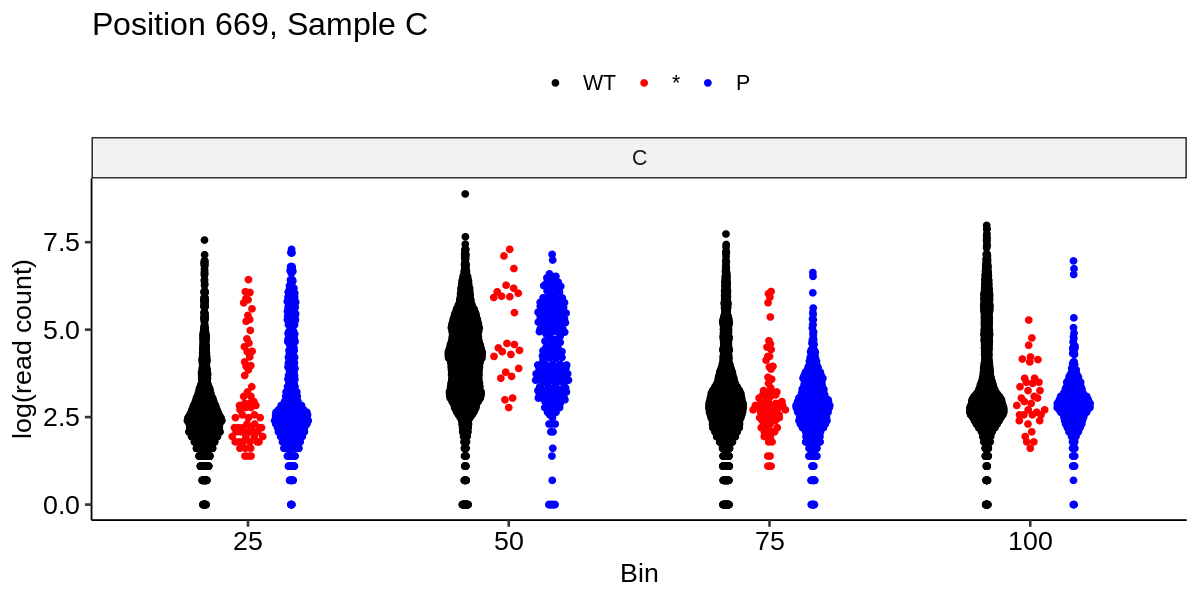

In [29]:
options(repr.plot.width = 10, repr.plot.height = 5)

model_counts %>% 
    filter(mut_aa %in% c("WT", "P", "*")) %>%
    mutate(condition_conc = factor(condition_conc, levels = c(25, 50, 75, 100))) %>%
    ggplot() +
        geom_quasirandom(aes(x = condition_conc, y = log(count),
                             color = mut_aa), dodge.width = 0.5)  +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("log(read count)") +
        ggtitle("Position 669, Sample C") +
        scale_color_manual(values = c("*" = "red", "P" = "blue", "WT" = "black")) +
        theme(legend.title = element_blank()) +
        facet_wrap(~str_sub(sample, 1, 1), ncol = 1)

Indeed, it does look like there are fewer unique barcodes in bin 50 and they generally have higher  read counts compared to the other three bins. This poses problems even for a simple ratio approach - if we took each barcode and computed the proportion of reads from a given barcode in that bin, many barcodes would appear "elevated" in bin 50. Let's see what we can do about that.

### Adapting the DMS Model to VAMP-seq <a name="part2"></a>

Recall that the main DMS model is specified as:

$$count \sim bin + bin:AA + (1|barcode) + offset(stopCount)$$

The issues described above are "normalized out" by comparison with WT, since WT provides the "within-bin" reference against which we compute variant effects. However, we would like (for many reasons) to be able to estimate WT indiviually as well, despite bin 50. One plausible solution could be the _offset_. In the main model, the offset is total stop counts, which is not appropriate given that stops will be very unevenly distributed across bins. Instead, the true offset here should be the _average_ read count instead of the general total or stop total. This results in a new model:

$$count \sim bin + bin:AA + (1|barcode) + offset(averageLogCount)$$

where `averageLogCount` is defined as the `mean(log(count))` for all counts from a given sample. If we run this model and extract the same marginals, with no other changes, we obtain:

NOTE: A nesting structure was detected in the fitted model:
    mut_aa %in% condition_conc



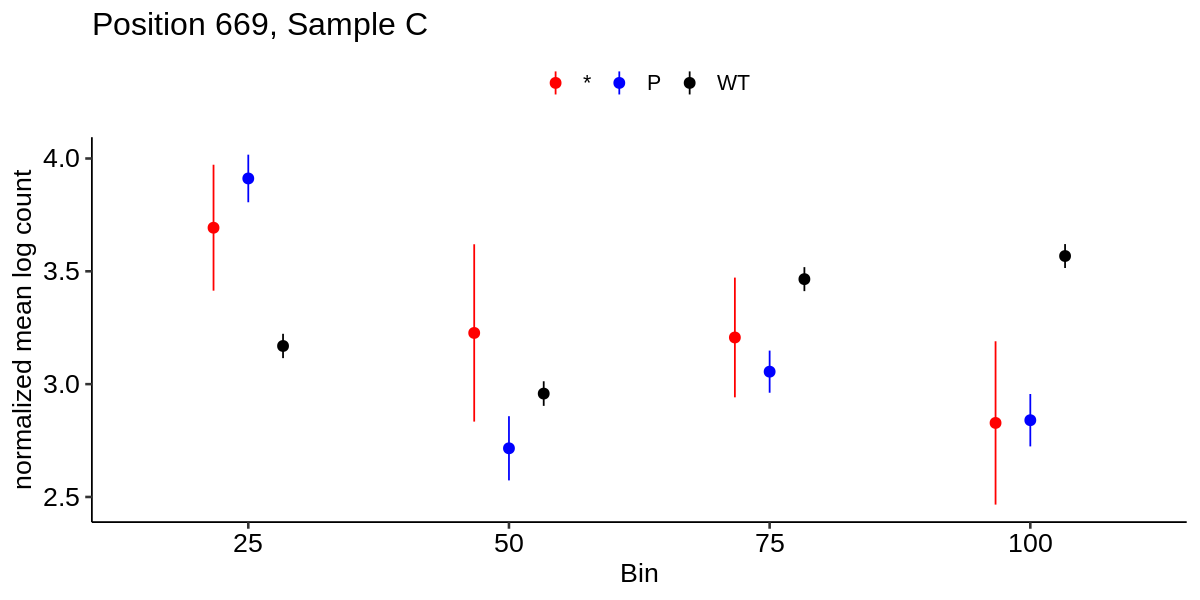

In [7]:
form <- as.formula(count ~ -1 + condition_conc + condition_conc:mut_aa + (1 | barcode) + offset(mean_count))
mod <- glmmTMB(formula = form,
            REML = TRUE,
            start = -1,
            control = glmmTMBControl(optimizer = optim,
                 optArgs = list(method = "L-BFGS-B",
                    pgtol = 0,
                    rel.tol = 0.1)),
            data = model_counts,
            family = nbinom2)

coefs <- tidy(emmeans(mod, ~mut_aa + condition_conc))

options(repr.plot.width = 10, repr.plot.height = 5)
coefs %>%
    filter(mut_aa %in% c("WT", "*", "P")) %>%
    mutate(condition_conc = factor(condition_conc, levels = c(25, 50, 75, 100))) %>%
    ggplot()  +
        geom_pointrange(aes(x = as.factor(condition_conc), y = (estimate),
                            ymin = (estimate - 2*std.error),
                            ymax = (estimate + 2*std.error),
                            color = mut_aa), position = position_dodge(width = 0.4)) +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("normalized mean log count") +
        ggtitle("Position 669, Sample C") +
        scale_color_manual(values = c("*" = "red", "P" = "blue", "WT" = "black")) +
        theme(legend.title = element_blank())

This looks much better! WT is more clearly elevated to the right, and the two LoF variants are elevated to the left with the proline more negative than the stop (which is plausible given the structure of this assay). The wide standard errors are to be expected given that this is only sample C, and the generally weaker effect of stops here. We can extract and plot the mutant vs WT effects to generate a plot identical to that from the original model but with this change:

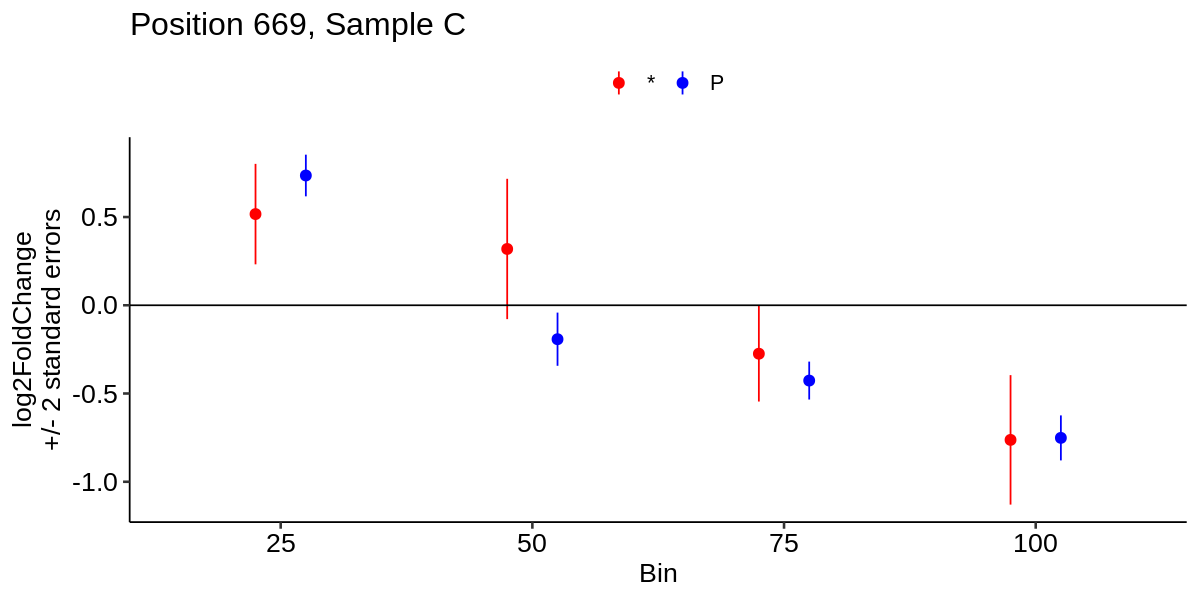

In [448]:
tidy(mod) %>%
    filter(grepl("P|\\*", term)) %>%
    mutate(term = gsub("condition_conc|mut_aa", "", term)) %>%
    separate(term, c("bin", "aa"), ":") %>%
    dplyr::select(bin, aa, estimate, std.error) %>%
    mutate(bin = factor(bin, levels = c(25, 50, 75, 100))) %>%
    ggplot()  +
        geom_pointrange(aes(x = as.factor(bin), y = (estimate),
                            ymin = (estimate - 2*std.error),
                            ymax = (estimate + 2*std.error),
                            color = aa), position = position_dodge(width = 0.4)) +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("log2FoldChange\n+/- 2 standard errors") +
        ggtitle("Position 669, Sample C") +
        scale_color_manual(values = c("*" = "red", "P" = "blue", "WT" = "black")) +
        theme(legend.title = element_blank()) +
        geom_hline(yintercept = 0)

We generally see the same pattern, but shifted down a bit and with slightly smaller effect sizes _and_ standard errors (so similar significance results). However, the variant effects _across bins_ are much more left-shifted and (from the previous plot) have a reasonable WT profile.

### Rescaling Coefficients to Weights <a name="part3"></a>

Now, all this modeling so far relates a quantity shown on the y-axis (count/abundance or log2FoldChange) to the sample IDs on the x-axis. However, if we consider the x-axis bins as representing quantitative activity levels, we would like to compute a "midpoint" on a 0-1 scale of all activity from a given variant across bins.

To do this, we define a `score` computed as follows:

$$score = b_1w_1 + b_2w_2 + b_3w_3 + b_4w_4$$

where bins are ordered 1 through 4 in order of increasing activity. Here, $b_i$ indicates the activity level of the $ith$ bin, and $w_i$ indicates the `weight` of that bin. For our purposes, we set the $b_i$ equal to the midpoint of the bin, resulting in values of: `0.125`, `0.375`, `0.625`, and `0.875`.

However, that still leaves the question of determining appropriate values for the $w_i$. In the previous section, we noted that we can view a model in terms of the abundances of mutant and WT separately, or their log fold change. Let's consider one variant (669P) along with WT and how we might use regression summary statistics to compute weights:

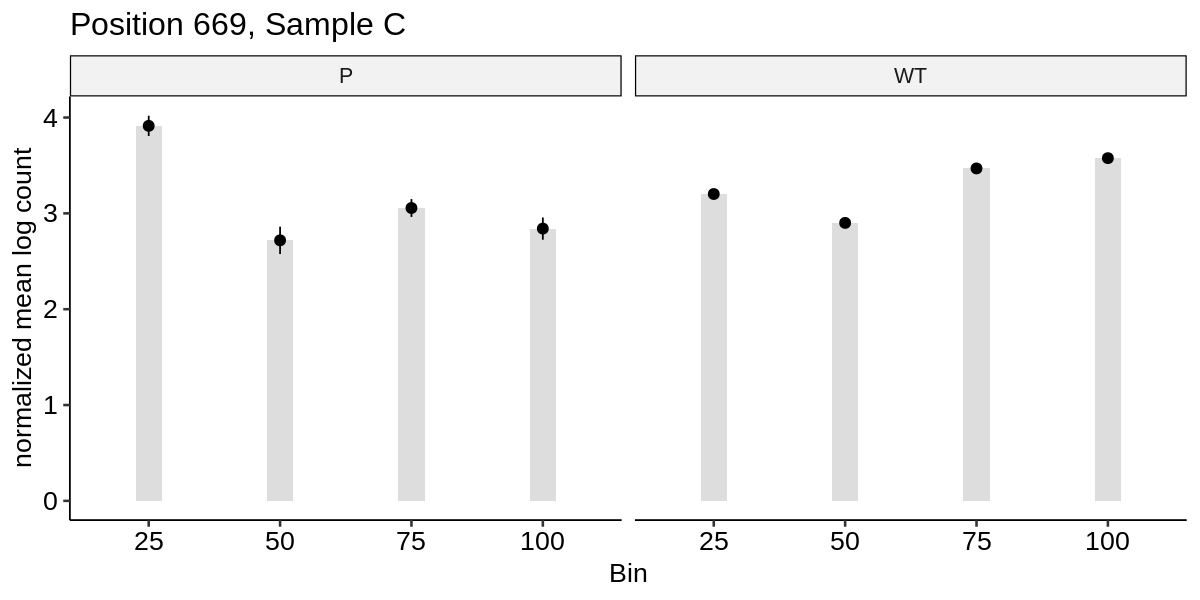

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
coefs %>%
    filter(mut_aa %in% c("WT", "P")) %>%
    mutate(condition_conc = factor(condition_conc, levels = c(25, 50, 75, 100))) %>%
    ggplot()  +
        geom_bar(aes(x = as.factor(condition_conc), y = (estimate)),
                 stat = "identity", width = 0.2, alpha = 0.2) +
        geom_pointrange(aes(x = as.factor(condition_conc), y = (estimate),
                            ymin = (estimate - 2*std.error),
                            ymax = (estimate + 2*std.error))) +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("normalized mean log count") +
        ggtitle("Position 669, Sample C") +
        theme(legend.title = element_blank()) +
        facet_wrap(~mut_aa, nrow = 1, )

Next, we want to only consider _relative_ changes in mean count rather than the absolute change - if a variant shifts all-up or all-down relative to WT but with the same pattern, that would generally reflect a compositional issue rather than a biological effect. Thus, we _normalize_ these values by i) subtracting the smallest value and ii) dividing by the sum of the remaining values. 

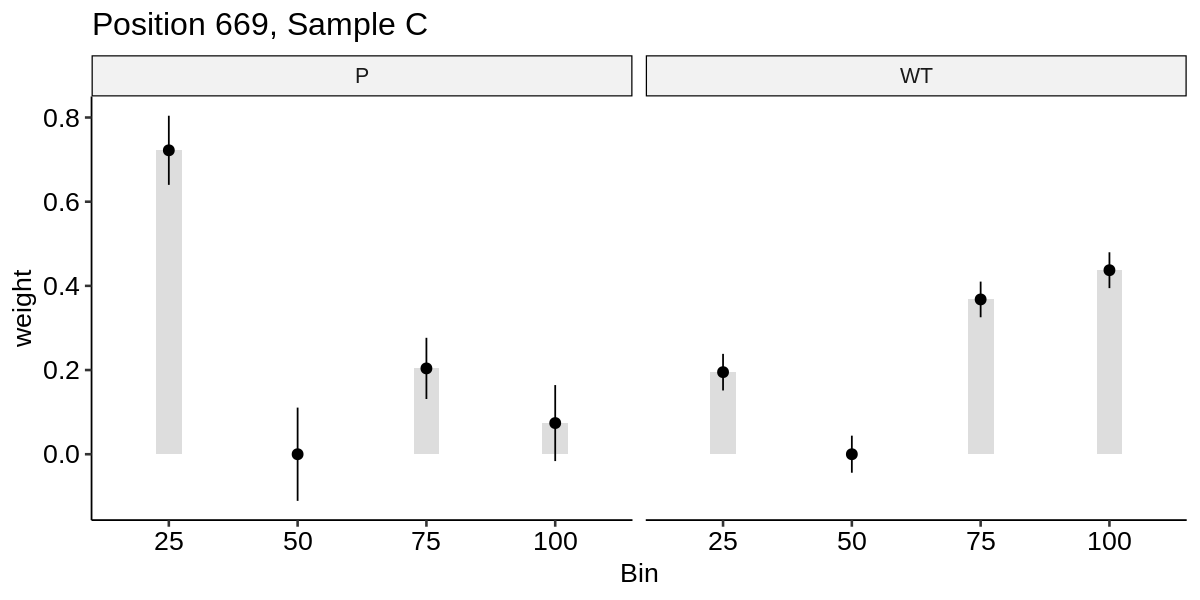

In [14]:
options(repr.plot.width = 10, repr.plot.height = 5)
coefs %>%
    filter(mut_aa %in% c("WT", "P")) %>%
    mutate(condition_conc = factor(condition_conc, levels = c(25, 50, 75, 100))) %>%
    group_by(mut_aa) %>%
    mutate(std.error = std.error / sqrt(sum(estimate - min(estimate))),
           estimate = (estimate - min(estimate))/sum(estimate - min(estimate))) %>%
    ggplot()  +
        geom_bar(aes(x = as.factor(condition_conc), y = (estimate)),
                 stat = "identity", width = 0.2, alpha = 0.2) +
        geom_pointrange(aes(x = as.factor(condition_conc), y = (estimate),
                            ymin = (estimate - 2*std.error),
                            ymax = (estimate + 2*std.error))) +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("weight") +
        ggtitle("Position 669, Sample C") +
        theme(legend.title = element_blank()) +
        facet_wrap(~mut_aa, nrow = 1, )

This is great! Now we have weights we can use to compute the score for each mutant and WT:

In [15]:
sum_coef <- coefs %>%
    filter(mut_aa %in% c("WT", "P")) %>%
    mutate(condition_conc = factor(condition_conc, levels = c(25, 50, 75, 100))) %>%
    group_by(mut_aa) %>%
    mutate(std.error = std.error / sqrt(sum(estimate - min(estimate))),
           estimate = (estimate - min(estimate))/sum(estimate - min(estimate))) %>%
    dplyr::select(mut_aa, condition_conc, estimate) %>%
    pivot_wider(names_from = condition_conc, values_from = estimate) %>%
    ungroup() %>%
    mutate(score = c(0.649125, 0.281125)) %>%
    relocate(c(mut_aa, `25`, `50`, `75`, `100`))

sum_coef

mut_aa,25,50,75,100,score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WT,0.1950280,0,0.3677614,0.43721054,0.649125
P,0.7220757,0,0.2038817,0.07404262,0.281125


In [16]:
unlist(sum_coef[1,2:5]) %*% c(0.125, 0.375, 0.625, 0.875)
unlist(sum_coef[2,2:5]) %*% c(0.125, 0.375, 0.625, 0.875)

0.6367886


0.2824728


Now, we would like to test for a difference between mutant and WT. To do this, we need some estimate of the error on these scores, which is very tricky given the post-processing of the regression coefficients we had to do.

### Inferring Differences from WT <a name="part4"></a>

Recall that the model provieds us a set of normalized log abundance estimates with standard errors for each bin and each variant, including WT. These errors are the only source of error or variance at all in the final score, but propagating the error from the regression outputs to that score is tricky and non-intuitive. An alternative is based in sampling - our regression outputs are Z-distributed (and tested with the Z-statistic), and so we can sample from them using the appropriate normal distribution.

To determine how variability in our abundance estimates propagates to our weights and final score, we can sample many sets of abundances to see how random changes (scaled by their standard errors) influence the final score. Let's walk through step-by-step:

First, we have the abundance estimates from the model:

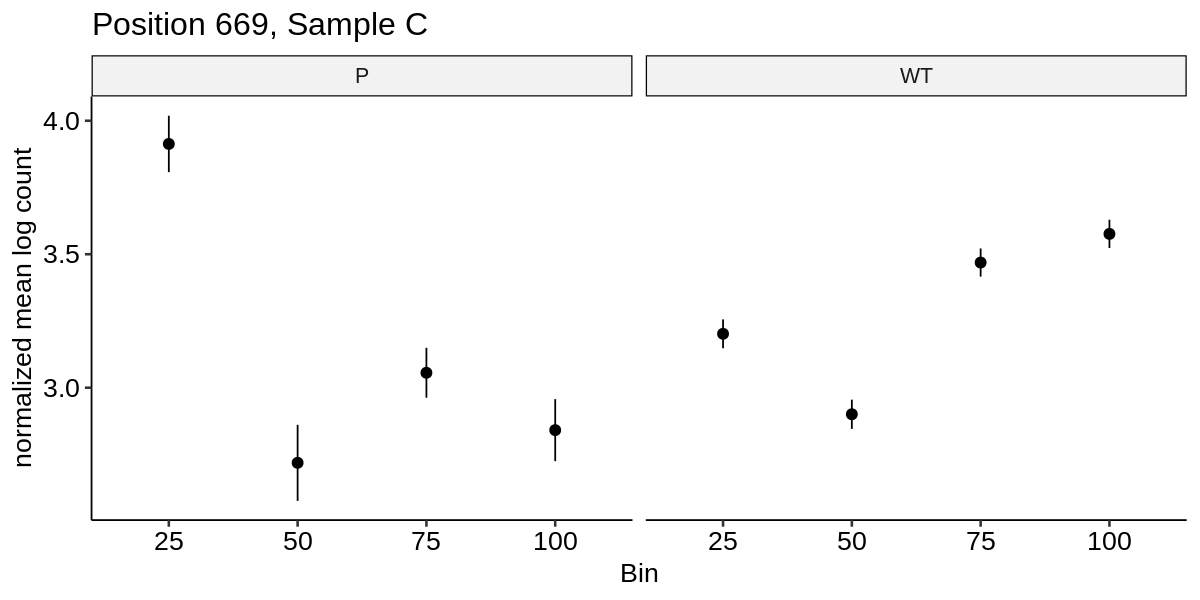

In [17]:
options(repr.plot.width = 10, repr.plot.height = 5)
coefs %>%
    filter(mut_aa %in% c("WT", "P")) %>%
    mutate(condition_conc = factor(condition_conc, levels = c(25, 50, 75, 100))) %>%
    ggplot()  +
        geom_pointrange(aes(x = as.factor(condition_conc), y = (estimate),
                            ymin = (estimate - 2*std.error),
                            ymax = (estimate + 2*std.error))) +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("normalized mean log count") +
        ggtitle("Position 669, Sample C") +
        theme(legend.title = element_blank()) +
        facet_wrap(~mut_aa, nrow = 1, )

Next, we take the means and standard errors from this model and sample from them many times - below, we shown an example with a handful of points to illustrate:

In [72]:
library(MASS)
generate_resamples <- function(mean_vec, se_vec, num){
    
    df <- mvrnorm(n = num,
                  mu = mean_vec,
                  Sigma = diag(se_vec^2)) %>%
        as_tibble() %>%
        mutate(n = row_number()) %>%
        rename(c("0.125" = "V1", "0.375" = "V2", "0.625" = "V3", "0.875" = "V4")) %>%
        pivot_longer(names_to = "bin", values_to = "value", `0.125`:`0.875`)
    
    return(df)
    
}

In [23]:
m <- coefs %>%
    filter(mut_aa %in% c("P")) %>%
    pull(estimate) %>%
    rev()

s <- coefs %>%
    filter(mut_aa %in% c("P")) %>%
    pull(std.error) %>%
    rev()

resamp_669p <- generate_resamples(m, s, 10000) %>%
    mutate(bin = factor(bin, levels = c(0.125, 0.375, 0.625, 0.875)),
           mut_aa = "P")

In [24]:
m <- coefs %>%
    filter(mut_aa %in% c("WT")) %>%
    pull(estimate) %>%
    rev()

s <- coefs %>%
    filter(mut_aa %in% c("WT")) %>%
    pull(std.error) %>%
    rev()

resamp_669wt <- generate_resamples(m, s, 10000) %>%
    mutate(bin = factor(bin, levels = c(0.125, 0.375, 0.625, 0.875)),
           mut_aa = "WT")

In [25]:
resamp_data <- bind_rows(resamp_669p %>% head(400),
                         resamp_669wt %>% head(400))

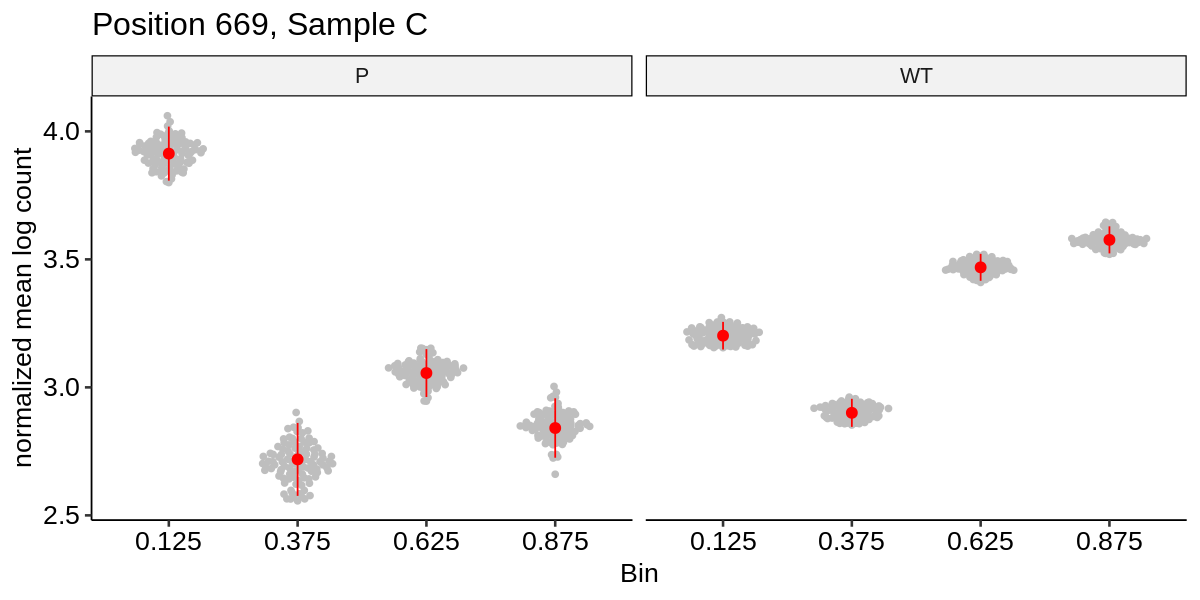

In [26]:
options(repr.plot.width = 10, repr.plot.height = 5)
coefs %>%
    filter(mut_aa %in% c("WT", "P")) %>% 
    mutate(condition_conc = case_when(condition_conc == 25 ~ 0.125,
                                      condition_conc == 50 ~ 0.375,
                                      condition_conc == 75 ~ 0.625,
                                      condition_conc == 100 ~ 0.875),
           condition_conc = factor(condition_conc, c(0.125, 0.375, 0.625, 0.875))) %>%
    ggplot()  +
        geom_quasirandom(data = resamp_data,
                         aes(x = as.factor(bin), y = value),
                         width = 0.3, color = "gray") +
        geom_pointrange(aes(x = as.factor(condition_conc), y = (estimate),
                            ymin = (estimate - 2*std.error),
                            ymax = (estimate + 2*std.error)), color = "red") +
        theme_pubr(base_size = 16) +
        xlab("Bin") + ylab("normalized mean log count") +
        ggtitle("Position 669, Sample C") +
        theme(legend.title = element_blank()) +
        facet_wrap(~mut_aa, nrow = 1, )

Then, we can compute the score for each simulated set of points after following the same procedure as before:

- Subtract the smallest value
- Divide by the sum of the remaining three values to obtain the weights $w_i$
- Compute the score as $\sum_iw_is_i$ for $s_i \in {0.125, 0.375, 0.625, 0.875}$

If we do this many more times (here, 10000) we obtain the following distributions:

`summarise()` has grouped output by 'n'. You can override using the `.groups`
argument.


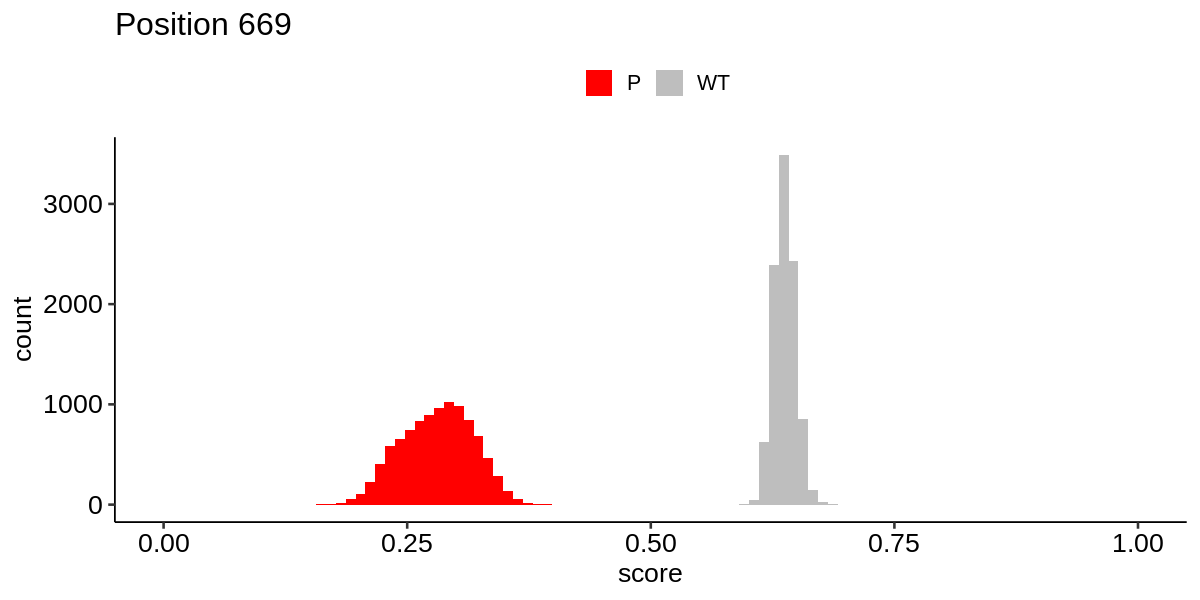

In [27]:
options(warn = -1)
bind_rows(resamp_669p,
          resamp_669wt) %>%
    mutate(bin = as.numeric(as.character(bin))) %>%
    group_by(n, mut_aa) %>%
    mutate(value = (value - min(value)) / sum(value - min(value))) %>%
    summarize(score = sum(bin*value)) %>%
    ggplot() +
        geom_histogram(aes(x = score, fill = mut_aa), bins = 100, color = NA) +
        theme_pubr(base_size = 16) +
        xlim(c(0,1)) +
        scale_fill_manual(values = c("WT" = "gray", "P" = "red")) +
        ggtitle("Position 669") +
        theme(legend.title = element_blank())

We can do hypothesis testing and other types of inference on these distributions, but the main quantity we are interested in is their mean and standard deviation, the latter corresponding to the standard error of our estimated quantity. Here, we can extract the mean and SD of these distributions and test for a difference between P and WT:

In [28]:
scores_669 <- bind_rows(resamp_669p,
          resamp_669wt) %>%
    mutate(bin = as.numeric(as.character(bin))) %>%
    group_by(n, mut_aa) %>%
    mutate(value = (value - min(value)) / sum(value - min(value))) %>%
    summarize(score = sum(bin*value)) 

`summarise()` has grouped output by 'n'. You can override using the `.groups`
argument.


In [29]:
scores_669 %>%
    ungroup() %>%
    group_by(mut_aa) %>%
    summarize(estimate = mean(score),
              std.error = sd(score)) %>%
    pivot_wider(names_from = mut_aa, values_from = c(estimate, std.error)) %>%
    mutate(estimate = `estimate_P` - estimate_WT,
              std.error = sqrt(`std.error_P`^2 + std.error_WT^2),
              statistic = estimate/std.error) %>%
    kable("markdown")



| estimate_P| estimate_WT| std.error_P| std.error_WT|   estimate| std.error| statistic|
|----------:|-----------:|-----------:|------------:|----------:|---------:|---------:|
|  0.2806714|   0.6372446|   0.0367323|    0.0110475| -0.3565732| 0.0383576| -9.296014|

### Extension to Chunk 10 <a name="part5"></a>

We set the bin values to their midpoints of 0.125, 0.375, 0.625, and 0.875. Then, we compute the weights and midpoints by resampling from the marginals extracted from the negative binomial model. Notably, we get a value of WT for each position (and all these values are extremely similar but not identical) so we specify the WT value as the median mean and median standard error across all positions. Doing so returns the following WT estimates:

In [5]:
generate_resamples <- function(mean_vec, se_vec, metadata, num){
    
    df <- mvrnorm(n = num,
                  mu = mean_vec,
                  Sigma = diag(se_vec^2)) %>%
        as_tibble() %>%
        mutate(n = row_number()) %>%
        rename(c("0.125" = "V1", "0.375" = "V2", "0.625" = "V3", "0.875" = "V4")) %>%
        pivot_longer(names_to = "bin", values_to = "value", `0.125`:`0.875`)

    df_score <- df %>%
        group_by(n) %>% 
        mutate(bin = as.numeric(bin),
               value = (value - min(value)) / sum(value - min(value))) %>%
        summarize(score = sum(bin*value)) 
    
    return(bind_cols(tibble("score_mean" = mean(df_score$score), "score_sd" = sd(df_score$score)),
                     metadata))
    
}

full_sumstats <- read_tsv("../sumstats/TYK2-VAMP/midpoint/tyk2-vamp-mini_10-vampseq.sumstats.tsv")
marginals <- full_sumstats %>% filter(is.na(term))
coefs <- full_sumstats %>% filter(!is.na(term))

Rows: 11830 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): effect, component, group, term, mut_aa, version
dbl (9): chunk, pos, estimate, std.error, statistic, p.value, dispersion, co...
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
weights <- marginals %>%
    dplyr::select(condition_conc, pos, mut_aa, estimate, std.error) %>%
    rename("bin" = "condition_conc") %>%
    group_by(pos, mut_aa) %>%
    mutate(std.error = std.error / sqrt(sum(estimate - min(estimate))),
           estimate = (estimate - min(estimate))/sum(estimate - min(estimate)),
           bin = case_when(bin == 25 ~ 0.125,
                           bin == 50 ~ 0.375,
                           bin == 75 ~ 0.625,
                           TRUE ~ 0.875))

In [8]:
# this cell takes a few minutes to run
sample_stats <- weights %>% 
    group_by(pos, mut_aa) %>% 
    group_map(~generate_resamples(.x$estimate, .x$std.error, .y, num = 1000)) %>%
    bind_rows()

In [9]:
sample_stats %>%
    filter(mut_aa == "WT") %>% 
    summarize("WT score" = median(score_mean),
              "WT score standard error" = median(score_sd)) %>%
    kable("markdown")



|  WT score| WT score standard error|
|---------:|-----------------------:|
| 0.6756111|               0.0058894|

Similarly, we can take the mean and standard deviation of the scores computed for each variant across all simulations, and plot either the subtractive difference from WT (the contrast effect size) or the Z-statistic of the difference. Using the Z-statistic results in a plot that is quite similar to those for DMS, including the pronounced influence of the spike-ins:

In [14]:
sample_stats_test <- sample_stats %>%
    filter(mut_aa != "WT") %>%
    mutate(estimate = score_mean - 0.6756316,
           std.error = sqrt(score_sd^2 + 0.005852742^2),
           statistic = estimate/std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

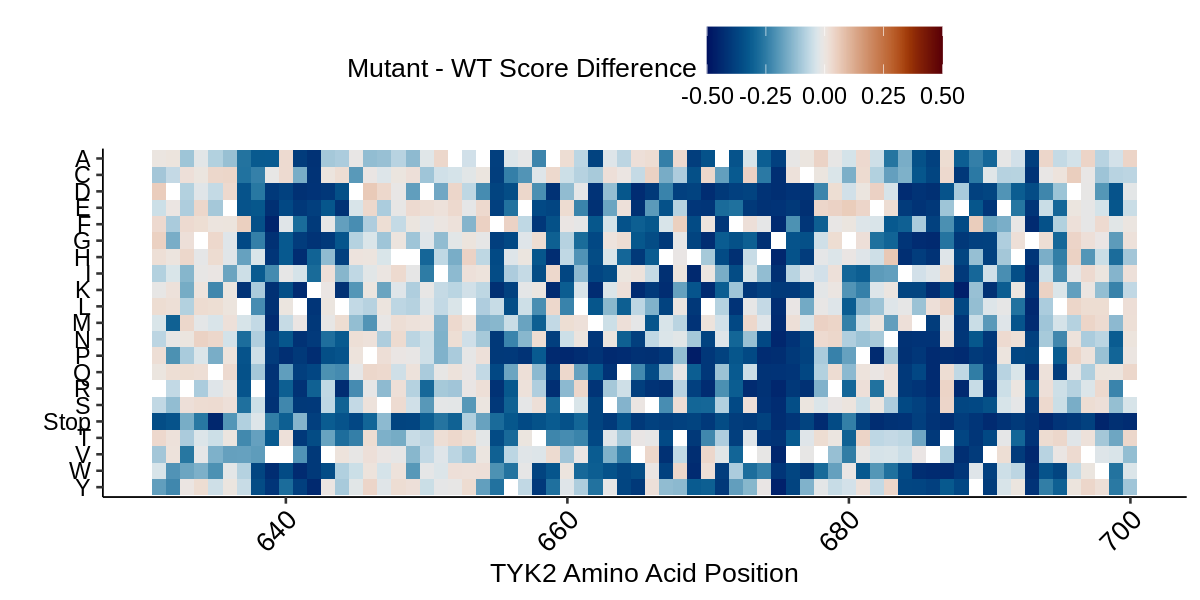

In [15]:
options(repr.plot.width = 10, repr.plot.height = 5)

sample_stats_test %>% 
    filter(mut_aa != "WT") %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("Mutant - WT Score Difference" = "estimate") %>%
     ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `Mutant - WT Score Difference`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish, limits = c(-0.5,0.5)) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position")

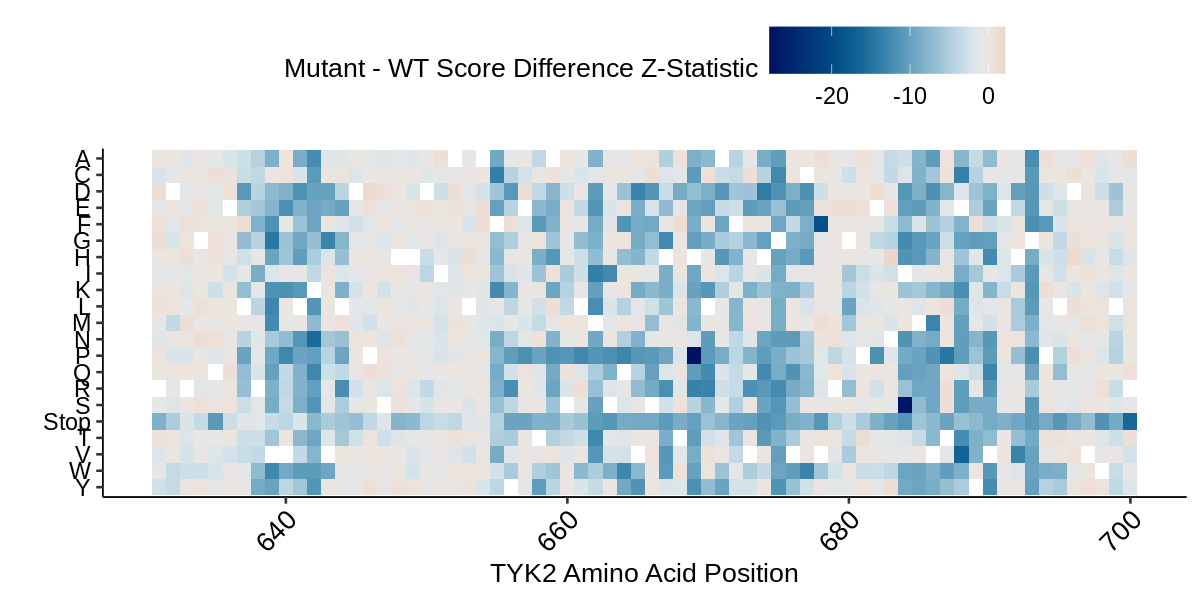

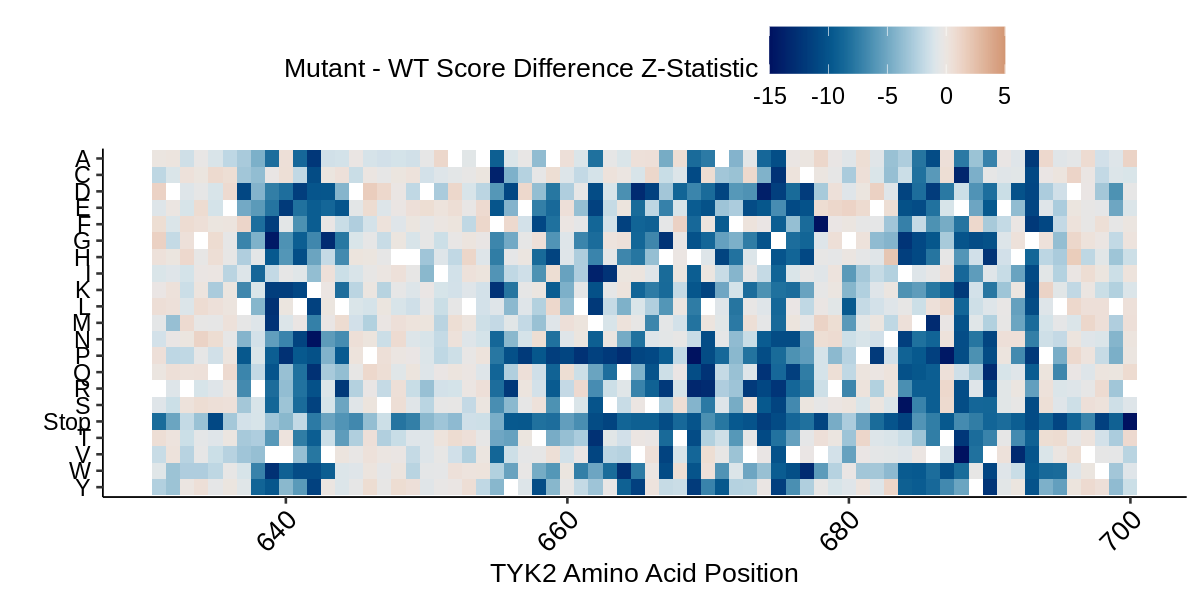

In [16]:
sample_stats_test %>% 
    filter(mut_aa != "WT") %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("Mutant - WT Score Difference Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `Mutant - WT Score Difference Z-Statistic`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position")

sample_stats_test %>% 
    filter(mut_aa != "WT") %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("Mutant - WT Score Difference Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `Mutant - WT Score Difference Z-Statistic`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish, limits = c(-15,5)) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position")

In [17]:
sample_stats_test %>%
    write_tsv("../sumstats/TYK2-VAMP/midpoint/vamp-10-midpoint-sumstats.tsv")